Downloading...
From (original): https://drive.google.com/uc?id=16y2xEwwuf1v_W0BUDv1thzpNu_dnaJZ1
From (redirected): https://drive.google.com/uc?id=16y2xEwwuf1v_W0BUDv1thzpNu_dnaJZ1&confirm=t&uuid=015fb8fc-d2ce-4a8a-83e8-e0cdbbc05b7d
To: /content/Real_and_Fake_Face_Detection.zip
100%|██████████| 227M/227M [00:01<00:00, 225MB/s]


Dataset downloaded and extracted successfully.
Class: Real, Number of images: 1081
Class: Fake, Number of images: 960


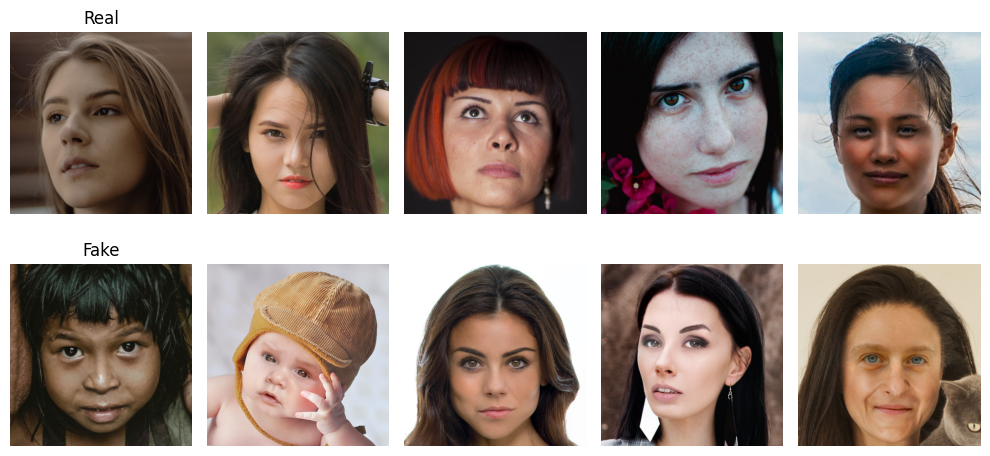

Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.
Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 0.8191 - accuracy: 0.5083

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 61s 790ms/step - loss: 0.8191 - accuracy: 0.5083 - val_loss: 0.6921 - val_accuracy: 0.5294 - lr: 1.0000e-04
Epoch 2/20
52/52 [==============================] - 39s 753ms/step - loss: 0.7527 - accuracy: 0.5138 - val_loss: 0.7024 - val_accuracy: 0.5294 - lr: 1.0000e-04
Epoch 3/20
52/52 [==============================] - 39s 750ms/step - loss: 0.7294 - accuracy: 0.5279 - val_loss: 0.6946 - val_accuracy: 0.5294 - lr: 1.0000e-04
Epoch 4/20
52/52 [==============================] - 39s 754ms/step - loss: 0.7214 - accuracy: 0.5303 - val_loss: 0.7409 - val_accuracy: 0.5294 - lr: 1.0000e-04
Epoch 5/20
52/52 [==============================] - 39s 750ms/step - loss: 0.7019 - accuracy: 0.5407 - val_loss: 0.9188 - val_accuracy: 0.5294 - lr: 1.0000e-04
Epoch 6/20
52/52 [==============================] - 39s 751ms/step - loss: 0.7035 - accuracy: 0.5352 - val_loss: 0.7431 - val_accuracy: 0.5147 - lr: 1.0000e-04
Epoch 7/20
52/52 [==============================] -

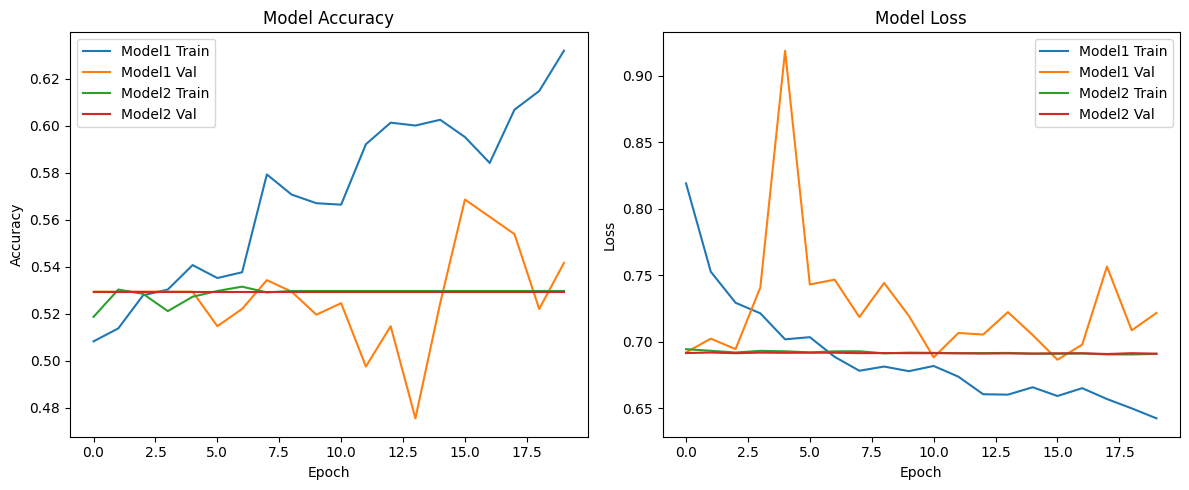

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Models saved and ready for download. You can now use these models to build your Hugging Face application.


In [5]:
# -*- coding: utf-8 -*-
"""Real_vs_AI_Face_Classification.ipynb"""

# Install required packages
!pip install gdown matplotlib seaborn tensorflow

import gdown
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Download and extract the dataset
url = 'https://drive.google.com/uc?id=16y2xEwwuf1v_W0BUDv1thzpNu_dnaJZ1'
output = 'Real_and_Fake_Face_Detection.zip'
gdown.download(url, output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('Real_and_Fake_Face_Detection')

os.remove(output)
print("Dataset downloaded and extracted successfully.")

# Analyze the dataset
def analyze_dataset(data_dir):
    dataset_dir = os.path.join(data_dir, 'Real and Fake Face Detection Dataset')
    class_names = [f for f in os.listdir(dataset_dir) if not f.startswith('.') and os.path.isdir(os.path.join(dataset_dir, f))]

    for class_name in class_names:
        class_dir = os.path.join(dataset_dir, class_name)
        num_images = len([f for f in os.listdir(class_dir) if not f.startswith('.')])
        print(f"Class: {class_name}, Number of images: {num_images}")

    # Plot sample images
    plt.figure(figsize=(10, 5))
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_dir, class_name)
        images = [f for f in os.listdir(class_dir) if not f.startswith('.')][:5]
        for j, image in enumerate(images):
            plt.subplot(2, 5, i*5 + j + 1)
            img = Image.open(os.path.join(class_dir, image))
            plt.imshow(img)
            plt.axis('off')
            if j == 0:
                plt.title(class_name)
    plt.tight_layout()
    plt.show()

analyze_dataset('Real_and_Fake_Face_Detection')

# Prepare the data
def prepare_data(data_dir, img_size=(224, 224), batch_size=32):
    dataset_dir = os.path.join(data_dir, 'Real and Fake Face Detection Dataset')
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        dataset_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        dataset_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'
    )

    return train_generator, validation_generator

# Define Model 1: Deep CNN with Residual Connections
def create_model1(input_shape=(224, 224, 3)):
    def residual_block(x, filters, kernel_size=3, stride=1):
        shortcut = x
        x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)
        x = tf.keras.layers.Add()([x, shortcut])
        return Activation('relu')(x)

    inputs = Input(shape=input_shape)
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    for filters in [64, 128, 256, 512]:
        x = residual_block(x, filters, stride=2)
        x = residual_block(x, filters)

    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Define Model 2: Inception-style Network
def create_model2(input_shape=(224, 224, 3)):
    def inception_module(x, filters):
        tower_1 = Conv2D(filters, 1, padding='same', activation='relu')(x)

        tower_2 = Conv2D(filters, 1, padding='same', activation='relu')(x)
        tower_2 = Conv2D(filters, 3, padding='same', activation='relu')(tower_2)

        tower_3 = Conv2D(filters, 1, padding='same', activation='relu')(x)
        tower_3 = Conv2D(filters, 5, padding='same', activation='relu')(tower_3)

        tower_4 = MaxPooling2D(3, strides=1, padding='same')(x)
        tower_4 = Conv2D(filters, 1, padding='same', activation='relu')(tower_4)

        return tf.keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4], axis=-1)

    inputs = Input(shape=input_shape)
    x = Conv2D(64, 7, strides=2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    x = inception_module(x, 64)
    x = inception_module(x, 128)
    x = MaxPooling2D(3, strides=2, padding='same')(x)

    x = inception_module(x, 256)
    x = inception_module(x, 512)
    x = GlobalAveragePooling2D()(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Train and evaluate models
def train_and_evaluate_model(model, model_name, train_generator, validation_generator):
    checkpoint = ModelCheckpoint(f'{model_name}_best.h5', save_best_only=True, monitor='val_accuracy', mode='max')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=20,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(validation_generator)
    print(f"{model_name} - Validation Loss: {loss:.4f}")
    print(f"{model_name} - Validation Accuracy: {accuracy:.4f}")

    return history

# Plot training history
def plot_training_history(history1, history2):
    plt.figure(figsize=(12, 5))

    plt.subplot(121)
    plt.plot(history1.history['accuracy'], label='Model1 Train')
    plt.plot(history1.history['val_accuracy'], label='Model1 Val')
    plt.plot(history2.history['accuracy'], label='Model2 Train')
    plt.plot(history2.history['val_accuracy'], label='Model2 Val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(122)
    plt.plot(history1.history['loss'], label='Model1 Train')
    plt.plot(history1.history['val_loss'], label='Model1 Val')
    plt.plot(history2.history['loss'], label='Model2 Train')
    plt.plot(history2.history['val_loss'], label='Model2 Val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Prepare data
    train_generator, validation_generator = prepare_data('Real_and_Fake_Face_Detection')

    # Create and train Model 1
    model1 = create_model1()
    history1 = train_and_evaluate_model(model1, "Model1_ResNet", train_generator, validation_generator)

    # Create and train Model 2
    model2 = create_model2()
    history2 = train_and_evaluate_model(model2, "Model2_Inception", train_generator, validation_generator)

    # Plot training history
    plot_training_history(history1, history2)

    # Save models for Hugging Face deployment
    model1.save('face_classification_model1.h5')
    model2.save('face_classification_model2.h5')

    # Download the saved models
    from google.colab import files
    files.download('face_classification_model1.h5')
    files.download('face_classification_model2.h5')

    print("Models saved and ready for download. You can now use these models to build your Hugging Face application.")

In [11]:
# Main execution
if __name__ == "__main__":


    # Download the saved models
    from google.colab import files
    files.download('face_classification_model1.h5')
    files.download('face_classification_model2.h5')

    print("Models saved and ready for download")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Models saved and ready for download


In [12]:
# Main execution
if __name__ == "__main__":


    # Download the saved models
    from google.colab import files

    files.download('face_classification_model2.h5')

    print("Models saved and ready for download")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Models saved and ready for download
